In [1]:
%matplotlib inline


迁移学习教程
==========================
**作者**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

这个教程将教你如何使用迁移学习训练你的网络.
你可以在 `cs231n 笔记 <http://cs231n.github.io/transfer-learning/>`__ 中
阅读更多有关迁移学习的信息.

引用自该笔记,

    事实上, 很少有人从头(随机初始化)开始训练一个卷积网络, 因为拥有一个足够大的数据库是比较少见的.
    替代的是, 通常会从一个大的数据集(例如 ImageNet, 包含120万的图片和1000个分类)预训练一个卷积网络,
    然后将这个卷积网络作为初始化的网络, 或者是感兴趣任务的固定的特征提取器.

如下是两种主要的迁移学习的使用场景:

-  **微调卷积网络**: 取代随机初始化网络, 我们从一个预训练的网络初始化, 
   比如从 imagenet 1000 数据集预训练的网络. 其余的训练就像往常一样.
-  **卷积网络作为固定的特征提取器**: 在这里, 我们固定网络中的所有权重, 最后的全连接层除外.
   最后的全连接层被新的随机权重替换, 并且, 只有这一层是被训练的.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

加载数据
---------

我们用 torchvision 和 torch.utils.data 包加载数据.

我们今天要解决的问题是, 训练一个可以区分 **ants** (蚂蚁) 和 **bees** (蜜蜂) 的模型.
用于训练的 ants 和 bees 图片各120张. 每一类用于验证的图片各75张.
通常, 如果从头开始训练, 这个非常小的数据集不足以进行泛化.
但是, 因为我们使用迁移学习, 应该可以取得很好的泛化效果.

这个数据集是一个非常小的 imagenet 子集

.. Note ::
   从`这里 <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_ 下载数据, 然后解压到当前目录.



In [3]:
# 训练要做数据增强和数据标准化
# 验证只做数据标准化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'G:\git\data\pytorch\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

F:\app\anaconda\lib\site-packages\torchvision\transforms\transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
F:\app\anaconda\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


显示一些图片
^^^^^^^^^^^^^^^^^^^^^^
让我们显示一些训练中的图片, 以便了解数据增强.



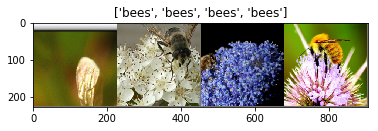

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停一会, 让 plots 更新


# 获得一批训练数据
inputs, classes = next(iter(dataloaders['train']))

# 从这批数据生成一个方格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

训练模型
------------------

现在, 让我们写一个通用的函数来训练模型. 这里, 我们将会举例说明:

-  调度学习率
-  保存最佳的学习模型

下面函数中, ``scheduler`` 参数是 ``torch.optim.lr_scheduler`` 中的 LR scheduler 对象.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每一个迭代都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # 设置 model 为训练 (training) 模式
            else:
                model.train(False)  # 设置 model 为评估 (evaluate) 模式

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for data in dataloaders[phase]:
                # 获取输入
                inputs, labels = data

                # 用 Variable 包装输入数据
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # 设置梯度参数为 0
                optimizer.zero_grad()

                # 正向传递
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # 如果是训练阶段, 向后传递和优化
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 统计
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深拷贝 model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型的权重
    model.load_state_dict(best_model_wts)
    return model

显示模型的预测结果
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

写一个处理少量图片, 并显示预测结果的通用函数




In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

调整卷积网络
----------------------

加载一个预训练的网络, 并重置最后一个全连接层.




In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# 如你所见, 所有参数都将被优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每 7 个迭代, 让 LR 衰减 0.1 因素
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\omf/.torch\models\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████| 46827520/46827520 [00:06<00:00, 7049751.00it/s]


训练和评估
^^^^^^^^^^^^^^^^^^

如果使用 CPU, 这将花费 15-25 分钟. 但使用 GPU 的话, 需要的时间将少于1分钟.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


F:\app\anaconda\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.8677 Acc: 0.0000
val Loss: 0.4228 Acc: 0.0000

Epoch 1/24
----------
train Loss: 0.7503 Acc: 0.0000
val Loss: 0.5269 Acc: 0.0000

Epoch 2/24
----------
train Loss: 0.5878 Acc: 0.0000
val Loss: 0.2492 Acc: 0.0000

Epoch 3/24
----------
train Loss: 0.8617 Acc: 0.0000
val Loss: 0.6213 Acc: 0.0000

Epoch 4/24
----------
train Loss: 0.5255 Acc: 0.0000
val Loss: 1.5421 Acc: 0.0000

Epoch 5/24
----------
train Loss: 0.7909 Acc: 0.0000
val Loss: 0.3589 Acc: 0.0000

Epoch 6/24
----------
train Loss: 0.6379 Acc: 0.0000
val Loss: 0.2888 Acc: 0.0000

Epoch 7/24
----------
train Loss: 0.3981 Acc: 0.0000
val Loss: 0.2394 Acc: 0.0000

Epoch 8/24
----------
train Loss: 0.3164 Acc: 0.0000
val Loss: 0.2388 Acc: 0.0000

Epoch 9/24
----------
train Loss: 0.2895 Acc: 0.0000
val Loss: 0.2421 Acc: 0.0000

Epoch 10/24
----------
train Loss: 0.3543 Acc: 0.0000
val Loss: 0.2220 Acc: 0.0000

Epoch 11/24
----------
train Loss: 0.2694 Acc: 0.0000
val Loss: 0.2148 Acc: 0.0000

Epoch 12/24
----------
t

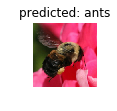

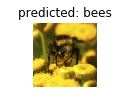

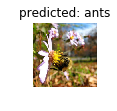

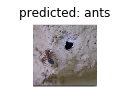

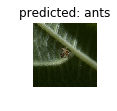

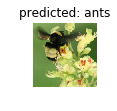

In [9]:
visualize_model(model_ft)

卷积网络作为固定的特征提取器
----------------------------------

这里, 我们固定网络中除最后一层外的所有权重. 为了固定这些参数, 我们需要设置 ``requires_grad == False`` ,
然后在 ``backward()`` 中就不会计算梯度.

你可以在 `这里 <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__ 阅读更多相关信息.



In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新构建的 module 的参数中, 默认设置了 requires_grad=True.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# 如你所见, 和我们前面提出的一样, 只有最后一层的参数被优化.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 每 7 个迭代, 让 LR 衰减 0.1 因素
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

训练和评估
^^^^^^^^^^^^^^^^^^

在使用 CPU 的情况下, 和前一个方案相比, 这将花费的时间是它的一半.
期望中, 网络的大部分是不需要计算梯度的. 前向传递依然要计算梯度.




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


F:\app\anaconda\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.5475 Acc: 0.0000
val Loss: 0.2045 Acc: 0.0000

Epoch 1/24
----------
train Loss: 0.6255 Acc: 0.0000
val Loss: 0.2805 Acc: 0.0000

Epoch 2/24
----------
train Loss: 0.5211 Acc: 0.0000
val Loss: 0.2033 Acc: 0.0000

Epoch 3/24
----------
train Loss: 0.4631 Acc: 0.0000
val Loss: 0.1916 Acc: 0.0000

Epoch 4/24
----------
train Loss: 0.4893 Acc: 0.0000
val Loss: 0.1667 Acc: 0.0000

Epoch 5/24
----------
train Loss: 0.4234 Acc: 0.0000
val Loss: 0.2199 Acc: 0.0000

Epoch 6/24
----------
train Loss: 0.4365 Acc: 0.0000
val Loss: 0.1911 Acc: 0.0000

Epoch 7/24
----------
train Loss: 0.2907 Acc: 0.0000
val Loss: 0.1868 Acc: 0.0000

Epoch 8/24
----------
train Loss: 0.3417 Acc: 0.0000
val Loss: 0.1982 Acc: 0.0000

Epoch 9/24
----------
train Loss: 0.3547 Acc: 0.0000
val Loss: 0.1960 Acc: 0.0000

Epoch 10/24
----------
train Loss: 0.3503 Acc: 0.0000
val Loss: 0.1904 Acc: 0.0000

Epoch 11/24
----------
train Loss: 0.4055 Acc: 0.0000
val Loss: 0.1761 Acc: 0.0000

Epoch 12/24
----------
t

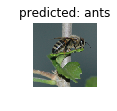

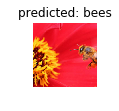

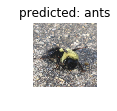

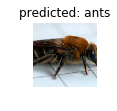

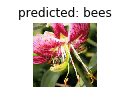

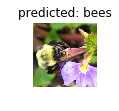

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()